# Investigating GPU acceleration for ABC Inference

[NOTE: This notebook needs to run on a GPU bento instance. To obtain one, follow steps given in https://fb.workplace.com/groups/ondemandgpu/]

GPU acceleration has revolutionized deep learning and has allowed architectues of scale never possible in the pre-GPU era. ABC technique shows promise of similar acceleration for Bayesian Inference, if it can benefit from GPUs.
In this notebook, we will try to answer the question: can Bayesian inference be GPU accelerated? We will focus on the most parallelizable form of Bayesian inference: Approximate Bayesian Computation (ABC). As an additional benefit, ABC only needs the code for the forward pass of the model to work, which is easy to compute on GPUs. The hope is that a GPU accelerated Bayesian inference engine could usher in new possibilites for Bayesian Models. 
The model under consideration is the bistable Hidden Markov Model (HMM). Here is a short description of the model:

The model consists of two states: A and B. If the probability of a transition from one state to the other is defined as $\theta$ in both directions, the probability to remain in the same state at each time step is 1 - $\theta$. The probability to measure the state correctly is $\gamma$ (conversely, the probability of an incorrect measurement is 1- $\gamma$.)
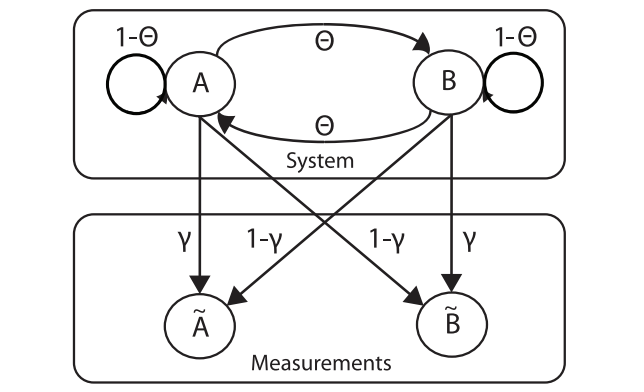
Due to various conditional dependencies across timesteps, likelihood of time series data can be tedious, which is why we choose this example to demonstrate ABC.

In [85]:
# Importing the required libraries
import torch
import torch.distributions as dist

## Switch device here and re-run to compare
The code in this notebook is designed to run on both CPU and GPU. To ensure data is sent to the relevant device, we decalre a `device` variable and use the `tensor().to(device)` while declaring tensors.

In [78]:
# uncomment line below to run in GPU
device = torch.device('cuda')

# # uncomment line below to run in CPU
# device = torch.device('cpu')

## Model definition

Let the hidden state and measured state of the system at time t be denoted by S(t) and M(t) respectively. 

For any given time t:

If S(t) = A,

P(S(t+1) = A) = 1- $\theta$; P(S(t+1) = B) = $\theta$

P(M(t+1) = A | S(t+1) = A) = $\gamma$; P(M(t+1)) = B | S(t+1) = A) = 1 - $\gamma$

Below we build the model using torch distributions so we can simulate some ground truth data. For ease we denote state A with 0 and state B with 1. Values for $\theta$ and $\gamma$ are typical and obtained from the referred work.

In [79]:
true_theta = 0.25

true_gamma = 0.99

num_observations = 1000

# tensorized data generator model
measurement_data = torch.zeros([num_observations]).to(device)
internal_states = torch.zeros([num_observations]).to(device)
def S(i):
    if i == 0:
        # start with default state 0
        internal_states[i] = torch.zeros(1)
        return internal_states[i]
    else:
        # current state opposite from previous with p=theta and same as previous with p=1-theta
        internal_states[i] = dist.Bernoulli((true_theta * (torch.ones(1).to(device) - internal_states[i-1])) 
                                   + (torch.ones(1).to(device) - true_theta) * internal_states[i-1]).sample()
        return internal_states[i]
def M(i):
    if i < num_observations:
        # measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
        hidden_state = S(i)
        measurement_data[i] = dist.Bernoulli((true_gamma * hidden_state) 
                                   + ((torch.ones(1).to(device) - true_gamma) * (1 - hidden_state))).sample()
        M(i+1)
    else:
        return measurement_data

## Generate mesurements from the model

In [80]:
M(0)
# let's print some for sanity check
print ([internal_states[i].item() for i in range(20)])
print ([measurement_data[i].item() for i in range(20)])

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


## Run inference on model with tensorized rejection ABC 
As a next step, we will perform rejection ABC on the same model to obtain posterior over the parameters. To do so we need the following:
- A summary statistic S: We will use this to guage the quality of the generated data in comparison with observed data. Here we use the frequency of switches as a summary statistic 
- A distance function $\rho$: to quantify the difference between generated data and observed data in the summary statistic. Here we use absolute distance, i.e. difference.
- Tolerence $\epsilon$: This is the threshold of acceptance, i.e. we will accept a sample if distance in summary statistic is within this range. We will choose 10% as per paper referred.

In [81]:
def switch_frequency(abc_samples):
    """
    Summary statistic for rejection ABC for bistable HMM model. 
    inputs: 2D binary tensor
    output: switching frequency of the array
    """
    switch_count = torch.zeros(abc_samples.shape[0]).to(device)
    num_abc_samples = abc_samples.shape[1]
    for i in range(1,num_abc_samples):
        switch_count +=  ~torch.eq(abc_samples[:,i], abc_samples[:, i-1])
    return switch_count.div_(num_abc_samples)


def abs_difference_accept(freq_1, freq_2, tolerance):
    return torch.lt(torch.abs(freq_1.sub_(freq_2)), tolerence)

# we accept samples with switch frequency within 10% of observed samples
tolerence = torch.tensor(0.1).to(device)

# we also compute the switch frequency of observed data
obs_switch_freq = switch_frequency(measurement_data.reshape([1,-1]))

print(f"Switching frequency of data: {obs_switch_freq.item()}")

Switching frequency of data: 0.27400001883506775


Now we define the rejection ABC version of the model:

In [82]:
# Priors: we will keep same priors as MH infernce
theta_prior = dist.Uniform(0, 1)

gamma_prior = dist.Beta(5, 0.75)

# number of parameter samples to consider in each iteration
N = 500000

# generate N samples each of theta and gamma from their prior
samples_theta = theta_prior.sample(torch.Size([N])).to(device)
samples_gamma = gamma_prior.sample(torch.Size([N])).to(device)

# tensorized data generator model
generated_data = torch.zeros([N,num_observations]).to(device)
internal_states = torch.zeros([N, num_observations]).to(device)
def S(i):
    if i == 0:
        # start with default state 0
        internal_states[:,i] = torch.zeros(N).to(device)
        return internal_states[:,i]
    else:
        # current state opposite from previous with p=theta and same as previous with p=1-theta
        internal_states[:, i] = dist.Bernoulli((samples_theta * (torch.ones(N).to(device) - internal_states[:, i-1])) 
                                   + (torch.ones(N).to(device) - samples_theta) * internal_states[:, i-1]).sample()
        return internal_states[:,i]
def M(i):
    if i < num_observations:
        # measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
        hidden_state = S(i)
        generated_data[:,i] = dist.Bernoulli((samples_gamma * hidden_state 
                                   + (torch.ones(N).to(device) - samples_gamma) * (1 - hidden_state))).sample()
        M(i+1)
    else:
        return generated_data

With all required tools, we will now start Rejection ABC process:

In [83]:
%%time
# perform 1 iteration of rejection ABC
M(0)
# compute summary statistic
sample_switch_frequencies = switch_frequency(generated_data)
# perform rejection
sample_accepted = abs_difference_accept(sample_switch_frequencies, obs_switch_freq, tolerence)
accepted_theta = torch.tensor(samples_theta[sample_accepted.nonzero()]).to(device)
accepted_gamma = torch.tensor(samples_gamma[sample_accepted.nonzero()]).to(device)

CPU times: user 2.68 s, sys: 300 ms, total: 2.98 s
Wall time: 2.98 s


In [84]:
# posterior statistics to make sure the inference works
acceptance_rate = accepted_theta.shape[0]/N
print(f"After one step of rejection ABC: \n\n Number of parameter samples: {N} \
        \n Mean of accepted theta: {accepted_theta.mean()} \
        \n Variance of accepted theta: {accepted_theta.var()} \
        \n Mean of accepted gamma: {accepted_gamma.mean()} \
        \n Variance of accepted gamma: {accepted_gamma.var()} \
        \n Acceptance_rate: {acceptance_rate}\n\n ")

After one step of rejection ABC: 

 Number of parameter samples: 500000         
 Mean of accepted theta: 0.19315031170845032         
 Variance of accepted theta: 0.008983679115772247         
 Mean of accepted gamma: 0.9219312071800232         
 Variance of accepted gamma: 0.0037733931094408035         
 Acceptance_rate: 0.190136

 


Please rerun the notebook twice, once with device = 'cpu' and another time with device = 'cuda' and observe the runtimes.

To summarize: 
With N = 500,000 samples, CPU runtime is ~66 s while GPU runtime is ~3 s

Hence this notebook demonstrates that for the Bistable HMM, ABC inference can be accelerated by a factor of 22x for sample size of 500k

Model reference: https://doi.org/10.1371/journal.pcbi.1002803